# CIFAR10 - ResNet50

_using a pretrained ResNet50 model_ 

## Loading the Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
from tensorflow.keras import datasets
import numpy as np
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from sklearn.model_selection import train_test_split

In [ ]:
#Defining parameters
BATCH_SIZE = 32
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

### Loading Data


In [ ]:
#Creating the training and testing sets 
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

#Creating the Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1, shuffle = True)

## Data Preprocessing

### Normalizing the Data

preprocess_input() returns a tensor of type float32, it subtracts the mean RGB channels of the ImageNet dataset.

The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

In [ ]:
#Defining function to normalise image using the preprocess_input() function in ResNet

def preprocess_data(input_images):
  #converts the type of values to float32 to ensure compatibility with the the preprocess_input() fxn  
  input_images = input_images.astype('float32')  
  output_images = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_images

In [ ]:
X_train = preprocess_data(X_train)
X_val = preprocess_data(X_val)

In [ ]:
print("X_train: max = ", X_train.max(), " min = ", X_train.min())
print("X_val: max = ", X_val.max(), " min = ", X_val.min())

X_train: max =  151.061  min =  -123.68
X_val: max =  151.061  min =  -123.68


In [ ]:
print("X_train = ", X_train.shape)
print("X_val = ", X_val.shape)

X_train =  (40000, 32, 32, 3)
X_val =  (10000, 32, 32, 3)


## ResNet50

Will load pretrained imagenet weights to the model

Will retain all the layers of the ResNet50 + final classification layers.


**Why do ResNets Work?**

Resnets work as it is easier the residual blocks to learn as compared to traditional NN. 

Input to a layer = x
Output of a layer = H(x)
Residue = R(x)

Therefore, R(x) = H(x) - x, rearranging this would give us, H(x) = R(x) + x, 
the residual block is hence, trying to learn the residual instead of the output H(x) unlike layers in traditional NN. 

Another advantage of ResNets is that it is less susceptible to Vanishing Gradients, this could probably be because, in resnets, some of the layers are skipped, hence, a layer l+g, can receive information/gradients from both the layer l+g-1 and from the layer l, where the gradient of l can be much larger than that of l+g, hence the problem of vanishing gradients is mitigated. 

**BackProp in ResNets**

The partial derivatives are passed directly to the previous layers + the residual. Gradients passed through residual blocks are multiplied by 1 as its an identity function.

In [ ]:
#Pretrained weights used, input size 224x224x3
"""
we treat the pre-trained network as an arbitrary feature extractor, allowing the input image to propagate forward, 
stopping at pre-specified layer, and taking the outputs of that layer as our features.
This allows us to obtain the features which the current model has not been trained on too.

Here we'll be using the ResNet50 model without including the fully connected layers, hence 
"""
#can mention the input_shape as 32x32
#curse of dimensionality - input has lot of dimension, need lot of space to learn
def feature_extractor(inputs):
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')(inputs)
  return feature_extractor

In [ ]:
#Defining the final Dense Layers and subsequnt softmax layer for classification
"""
GlobalAvergaePooling - The idea is to generate one feature map for each 
corresponding category of the classification task in the last conv layer. 
Instead of adding fully connected layers on top of the feature maps,
we take the average of each feature map, and the resulting vector is fed 
directly into the softmax layer. 

(+): no parameter to optimize, thereofre overfitting is avoided
(+): more robust to spatial translations of the input as it sums out the 
     spatial info
(+): more native to conv structure, therefore, enforces correspondence to 
     feature maps and categories
"""
def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation = "relu")(x)
  x = tf.keras.layers.Dense(512, activation = "relu")(x)
  x = tf.keras.layers.Dense(10, activation = "softmax", name = "classification")(x)
  
  return x

In [ ]:
#We need to upsample the images in X_train by a factor of (7x7) as the input image dimension is 32x32x3 to 
#transform it to 224x224,
                        # [1 2    with a factor of 2,2
 #                         3 4]
 #will become:
 #[1 1 2 2 
 # 1 1 2 2 
 # 3 3 4 4 
 # 3 3 4 4 ]

#COmbined model of the ResNet50 classification
def combined_model(inputs):
  resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

  #Extract the features out
  resnet_feature_extractor = feature_extractor(resize)
  #Send it through the classifier
  classification_output = classifier(resnet_feature_extractor)

  return classification_output

In [ ]:
#Build the actual model
def build_model():
  inputs = tf.keras.layers.Input(shape = (32, 32, 3))

  classification_output = combined_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs=classification_output)

  model.compile(optimizer = 'SGD',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [ ]:
#Compiling the Model
model = build_model()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800

In [ ]:
# TRAIN 
history = model.fit(X_train, y_train, epochs = 3, validation_data = (X_val, y_val), batch_size = 64)

Epoch 1/3
625/625 [==============================] - 24922s 40s/step - loss: 0.4401 - accuracy: 0.8547 - val_loss: 0.2588 - val_accuracy: 0.9116
Epoch 2/3
625/625 [==============================] - 18496s 30s/step - loss: 0.1120 - accuracy: 0.9640 - val_loss: 0.1723 - val_accuracy: 0.9405
Epoch 3/3
625/625 [==============================] - 15430s 25s/step - loss: 0.0403 - accuracy: 0.9882 - val_loss: 0.1612 - val_accuracy: 0.9485


In [ ]:
model.save('final_model_best_resnet50.h5')

C:\Users\sgrasat\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Evalauating the Model

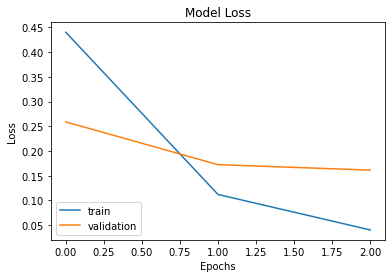

In [ ]:
#Plotting the Loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

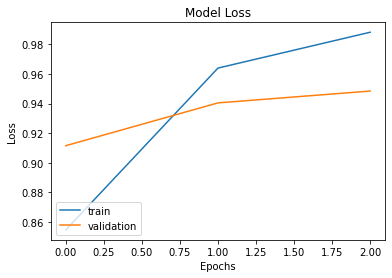

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

## Predictions

In [ ]:
predictions = model.predict(X_test)
predictions

array([[2.1954566e-02, 4.6969228e-03, 1.0467901e-02, ..., 1.6047850e-02,
        1.2191636e-03, 6.5584774e-03],
       [3.5018463e-02, 8.5762196e-04, 6.6959015e-05, ..., 9.6078093e-06,
        9.6207798e-01, 1.5520584e-04],
       [1.9804463e-03, 3.5989541e-04, 1.7071065e-05, ..., 8.8269793e-05,
        9.9725807e-01, 2.0189967e-05],
       ...,
       [4.8382781e-06, 2.3596801e-06, 1.3281609e-03, ..., 2.7965591e-06,
        6.5870522e-06, 1.4359488e-06],
       [6.2123057e-04, 9.9920964e-01, 9.6628428e-05, ..., 4.6274722e-06,
        2.1768567e-05, 3.4403135e-07],
       [1.6746297e-05, 5.8376590e-06, 5.2886321e-06, ..., 9.9923646e-01,
        7.4580493e-07, 1.7197074e-06]], dtype=float32)

In [ ]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [ ]:
pred_classes = [np.argmax(element) for element in predictions]
pred_classes[:5]

[3, 8, 8, 0, 6]

In [ ]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [ ]:
import pandas as pd
y_flatten = y_test.flatten()
y_flatten

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

### Model's Prediction

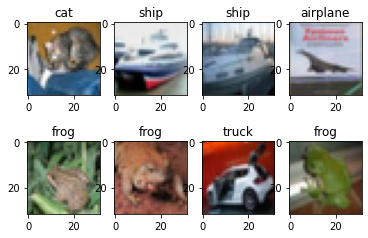

In [ ]:
import matplotlib.pyplot as plt
for i in range(8):
    # define subplot
    plt.subplot(2,4, i+1)
    plt.title(classes[pred_classes[i]])
    # plot raw pixel data
    plt.imshow(X_test[i])
# show the figure
plt.show()

### Ground truth Labels

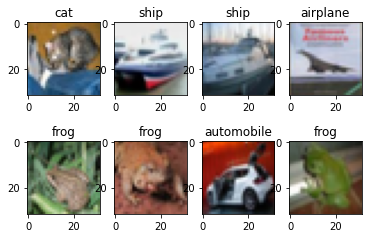

In [ ]:
for i in range(8):
    # define subplot
    plt.subplot(2,4, i+1)
    plt.title(classes[y_flatten[i]])
    # plot raw pixel data
    plt.imshow(X_test[i])
# show the figure
plt.show()

In [ ]:
from sklearn import metrics
print("Test Accuracy = ", metrics.accuracy_score(y_flatten, pred_classes))

Test Accuracy =  0.7891
